# Imports

In [2]:
import os
import random
import shutil
from collections import defaultdict
from PIL import Image, ImageEnhance, ImageOps, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# ------------------- Torch --------------------------------#
import torch
from torchvision.transforms.functional import to_pil_image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [3]:
# if GPU is available , use it while training 
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cpu'

# Load model

In [4]:
# Define your ResNet50 model
model = models.resnet50(pretrained=True)  # i had set it to true initially.

# Load the saved state dictionary
checkpoint = torch.load('./models/trained_model3.pth')

# Adjust the size of the fully connected layer weights
# Assuming you want to resize it to have 8 output units
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 8)  # Adjust the number of output units as needed

# Load state dictionary into model
model.load_state_dict(checkpoint, strict=False)  # Set strict to False to ignore missing keys

# Ensure the model is in evaluation mode
model.eval()

c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Load other files

In [5]:
root_dir = '../Downloading_images/data/'

In [6]:
# path to train and validation sets
train_dir= "../Downloading_images/data/train/" # path to the train folder
validation_dir= "../Downloading_images/data/val" # path to the validation folder
test_dir= "../Downloading_images/data/test" # path to the test folder

In [7]:
# variables for the paths.
train_dir = train_dir
validation_dir = validation_dir
test_dir = test_dir

In [8]:
# Define the path to the models folder
models_folder = './models/'

# Transform

In [9]:
width = 224
height = 224

train_transform  = transforms.Compose([
    # Resize Image
    transforms.Resize(size=(width, height)), 
    # Turn the image into a torch.
    transforms.ToTensor() 
])

validation_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])

test_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])

train_transform,validation_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ))

# Datasets

In [10]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=validation_transform)

test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 19112
    Root location: ../Downloading_images/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 1176
    Root location: ../Downloading_images/data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [11]:
# create with datasets.ImageFolder
train_set = DataLoader(dataset=train_data,
                            batch_size=32, # how many samples per batch?
                            num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                            shuffle=True) # shuffle the data?

validation_set = DataLoader(dataset=validation_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

test_set = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

train_set,validation_set, test_set

(<torch.utils.data.dataloader.DataLoader at 0x274bd7d9148>,
 <torch.utils.data.dataloader.DataLoader at 0x274bd7d92c8>)

# Labels

In [12]:
# I create train_data above , and I will use it here
label_dict = {y: x for x, y in train_data.class_to_idx.items()}
label_dict

{0: '130228',
 1: '47892',
 2: '48537',
 3: '48681',
 4: '593040',
 5: '59549',
 6: '83653',
 7: '914922'}

In [13]:
class_weights = {
    47892: 0.3714,   # Impatiens glandulifera
    130228: 0.3025,  # Heracleum mantegazzianum
    914922: 0.1638,  # Reynoutria japonica
    59549: 0.0658,   # Lupinus polyphyllus
    48537: 0.0338,   # Lysichiton americanus
    83653: 0.0146,   # Rosa rugosa
    593040: 0.009,   # Reynoutria sachalinensis
    48681: 0.0034    # Spiraea
}

In [14]:
# Convert keys in label_dict to integers
label_dict_int = {int(key): value for key, value in label_dict.items()}
print(label_dict_int)

# Loop through each index in label_dict_int
for index, taxon_id in label_dict_int.items():
    # Retrieve the weight corresponding to the Taxon ID
    weight = class_weights.get(taxon_id)
    # If the weight exists, add it to the mapped dictionary
    if weight is not None:
        class_weights[taxon_id] = weight

print(class_weights)

{0: '130228', 1: '47892', 2: '48537', 3: '48681', 4: '593040', 5: '59549', 6: '83653', 7: '914922'}
{47892: 0.3714, 130228: 0.3025, 914922: 0.1638, 59549: 0.0658, 48537: 0.0338, 83653: 0.0146, 593040: 0.009, 48681: 0.0034}


 # 2 <span style="color:blue">Analysing the predictions</span>

## 2.1 Approximate Posterior Distribution

The approximate posterior distribution has been implicitly obtained during the training process <br>
by incorporating Bayesian priors. By adjusting the class weights as priors, the model learned to <br>
approximate the posterior distribution over the parameters. This approach allows the model to <br>
better handle class imbalances and uncertainties inherent in the data. Consequently, the model's <br>
predictions are informed not only by the observed data but also by the specified priors, <br>
resulting in more robust and reliable inference.<br>


## 2.2 Evaluation and Validation

Evaluate the performance of the model using validation data or through cross-validation techniques. <br>
This step helps ensure that the model generalizes well to unseen data and provides reliable predictions.<br>

In [15]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_set:
        # Preprocess the test data (if needed)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

# Compute additional evaluation metrics as needed
# e.g., precision, recall, F1-score, confusion matrix, etc.


Test Accuracy: 95.19%


### 2.2.1 Perform Prediction Sampling

prediction sampling by forwarding input images through the model with multiple sets of parameters <br>
sampled from the posterior distribution. This step involves accounting for parameter uncertainty, <br>
which is a key aspect of Bayesian inference.<br>
<br>
Below: performed prediction sampling and aggregated predictions using Monte Carlo dropout with your test dataset. <br>
Now, I have the aggregated predictions for each input image.<br>

In [16]:
# Check if the file exists
if os.path.exists('predictions.npy'):
    # Load predictions from the file
    all_predictions = np.load('predictions.npy', allow_pickle=True)
    print("Predictions loaded from file.")
else:
    # Run the prediction process
    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Perform prediction sampling and aggregate predictions
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_set:
            images = images.to(device)
            predictions = []
            for _ in range(10):  # usually 10-100
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                predictions.append(probabilities)
            all_predictions.append(np.mean(predictions, axis=0))

    # Save predictions to a file
    np.save('predictions.npy', all_predictions)
    print("Predictions saved to file.")

Predictions saved to file.


c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [17]:
num_classes = len(label_dict)
print(num_classes)

# Map class indices to labels
class_labels = [label_dict[i] for i in range(num_classes)]
print(class_labels)

8
['130228', '47892', '48537', '48681', '593040', '59549', '83653', '914922']


In [18]:
# Visualize posterior probabilities for the first image
posterior_probabilities = all_predictions[0] 

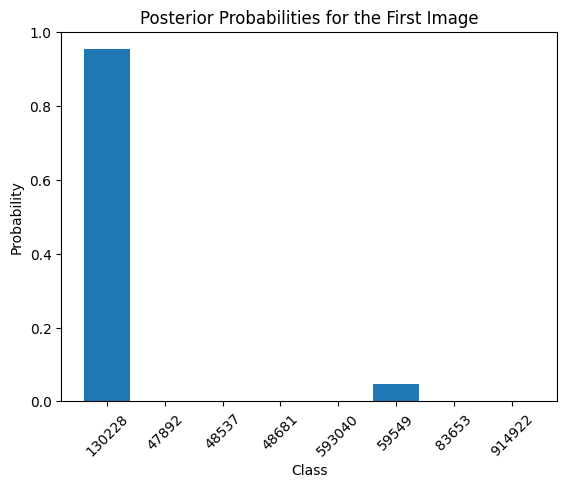

In [19]:
# Convert posterior probabilities to a numpy array
posterior_probabilities = np.array(posterior_probabilities[0])

# Create a bar plot
plt.figure()
plt.bar(np.arange(len(class_labels)), posterior_probabilities)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Posterior Probabilities for the First Image')
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.show()

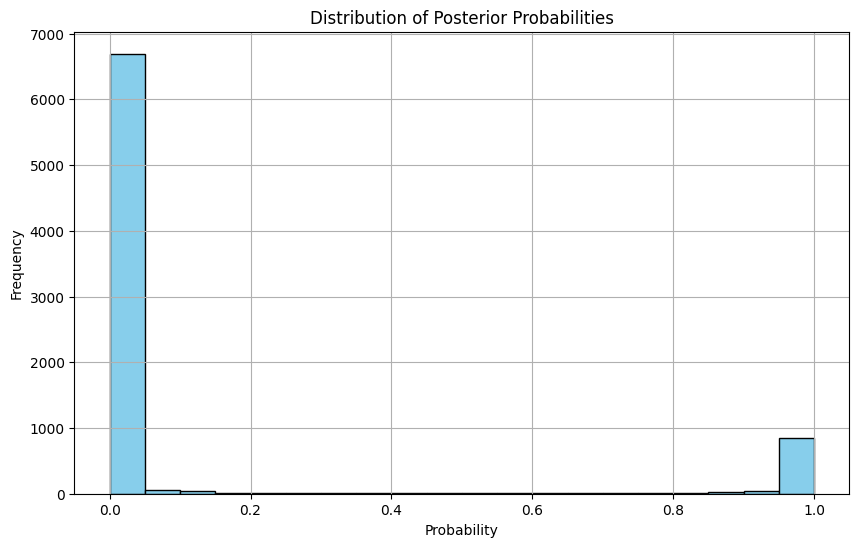

In [20]:
# Concatenate all posterior probabilities from all images
all_posterior_probabilities = np.concatenate(all_predictions, axis=0)

# Flatten the array to get a 1D array of probabilities
flat_posterior_probabilities = all_posterior_probabilities.flatten()

# Plot the histogram of posterior probabilities
plt.figure(figsize=(10, 6))
plt.hist(flat_posterior_probabilities, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Posterior Probabilities')
plt.grid(True)
plt.show()

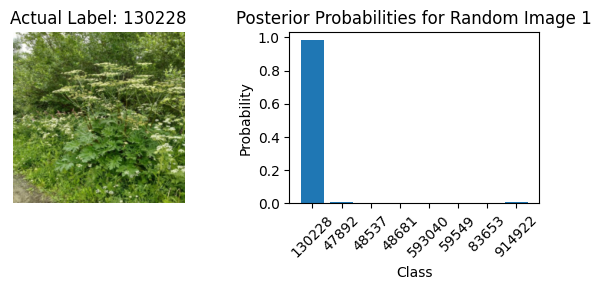

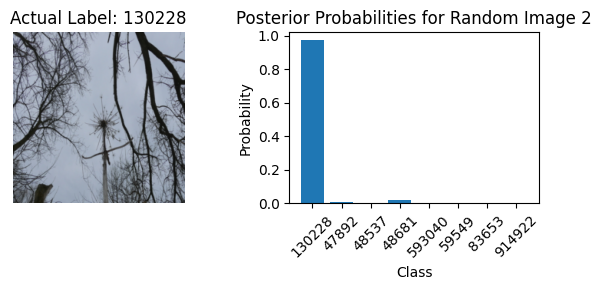

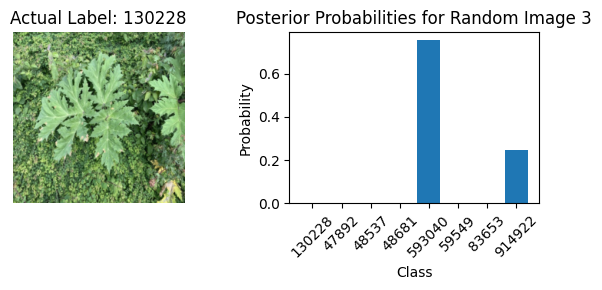

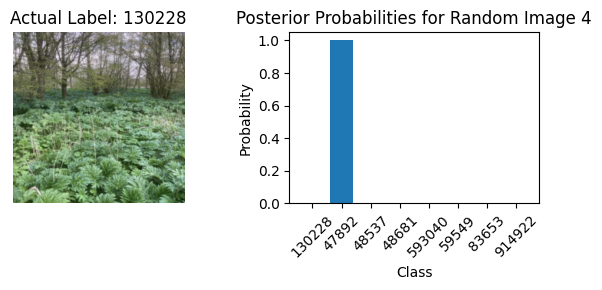

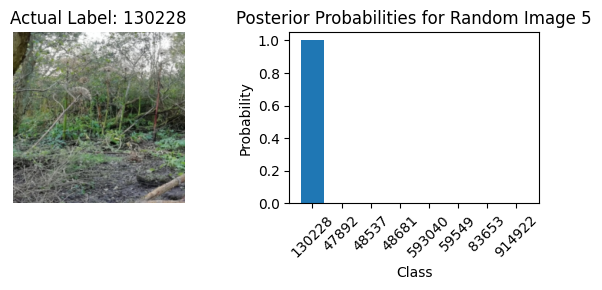

In [21]:
def visualize_random_images(all_predictions, label_dict, dataset, num_images=5):
    # Get the total number of images in the dataset
    total_images = len(dataset)

    # Generate random indices to select random images
    random_indices = random.sample(range(total_images), num_images)
    random_indices = [index % len(all_predictions) for index in random_indices]

    # Iterate over the randomly selected images
    for i, index in enumerate(random_indices):
        # Extract posterior probabilities for the current image
        posterior_probabilities = all_predictions[index]

        # Extracting class labels from the label dictionary
        class_labels = list(label_dict.values())

        # Convert posterior probabilities to a numpy array
        posterior_probabilities = np.array(posterior_probabilities[0])

        # Retrieve the actual image and its label from the dataset
        image, label_index = dataset[index]
        actual_label = label_dict[label_index]

        # Plot the image
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Assuming image is a PyTorch tensor
        plt.axis('off')
        plt.title(f'Actual Label: {actual_label}')

        # Create a bar plot for posterior probabilities
        plt.subplot(1, 2, 2)
        plt.bar(np.arange(len(class_labels)), posterior_probabilities)
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title(f'Posterior Probabilities for Random Image {i+1}')
        plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage: visualize posterior probabilities for 5 random images
visualize_random_images(all_predictions, label_dict, test_data, num_images=5)

## 2.3 Error Analysis
Analyze the relationship between uncertainty estimates and prediction errors. <br>
Identify instances where the model's uncertainty correlates with prediction errors.<br>
Understanding these relationships can provide insights into areas where the model <br>
struggles or where additional data may be needed for improved performance.<br>

In [22]:
prediction_probabilities = all_predictions  

# Extract true labels from your test dataset
true_labels = np.array([label for _, label in test_data])

In [23]:
len(true_labels)

978

In [24]:
len(prediction_probabilities)

31

In [25]:
prediction_probabilities = np.vstack(prediction_probabilities)

In [26]:
# Calculate prediction errors (cross-entropy loss)
# Use true labels to index prediction probabilities
prediction_errors = -np.log(prediction_probabilities[np.arange(len(true_labels)), true_labels])

In [27]:
# Calculate uncertainty measures (e.g., entropy)
entropy = -np.sum(prediction_probabilities * np.log(prediction_probabilities), axis=1)

# Calculate correlation between uncertainty and prediction errors
correlation = np.corrcoef(entropy, prediction_errors)[0, 1]

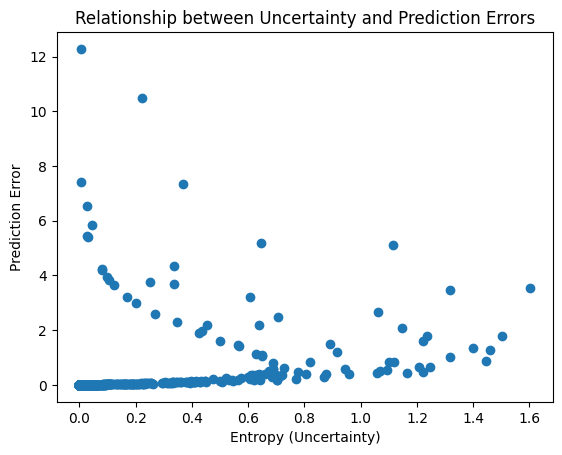

Correlation between uncertainty and prediction errors: 0.3140415871445269


In [28]:
# Visualize the relationship
plt.scatter(entropy, prediction_errors)
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Prediction Error')
plt.title('Relationship between Uncertainty and Prediction Errors')
plt.show()

print("Correlation between uncertainty and prediction errors:", correlation)

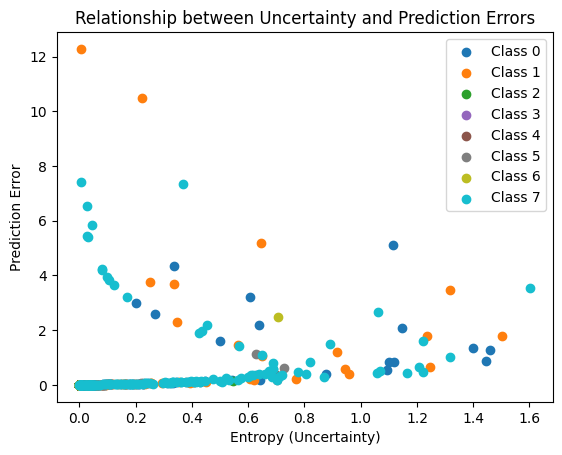

Correlation between uncertainty and prediction errors: 0.3140415871445269


In [29]:
# Get unique class labels
unique_labels = np.unique(true_labels)

# Create a colormap with a unique color for each class
num_classes = len(unique_labels)
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Plot each class separately with a unique color
for label, color in zip(unique_labels, colors):
    indices = np.where(true_labels == label)
    plt.scatter(entropy[indices], prediction_errors[indices], label=f'Class {label}', color=color)

plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Prediction Error')
plt.title('Relationship between Uncertainty and Prediction Errors')
plt.legend()
plt.show()

print("Correlation between uncertainty and prediction errors:", correlation)


 A correlation coefficient of 0.327 suggests a moderate positive correlation between uncertainty (entropy) and prediction errors in your case.

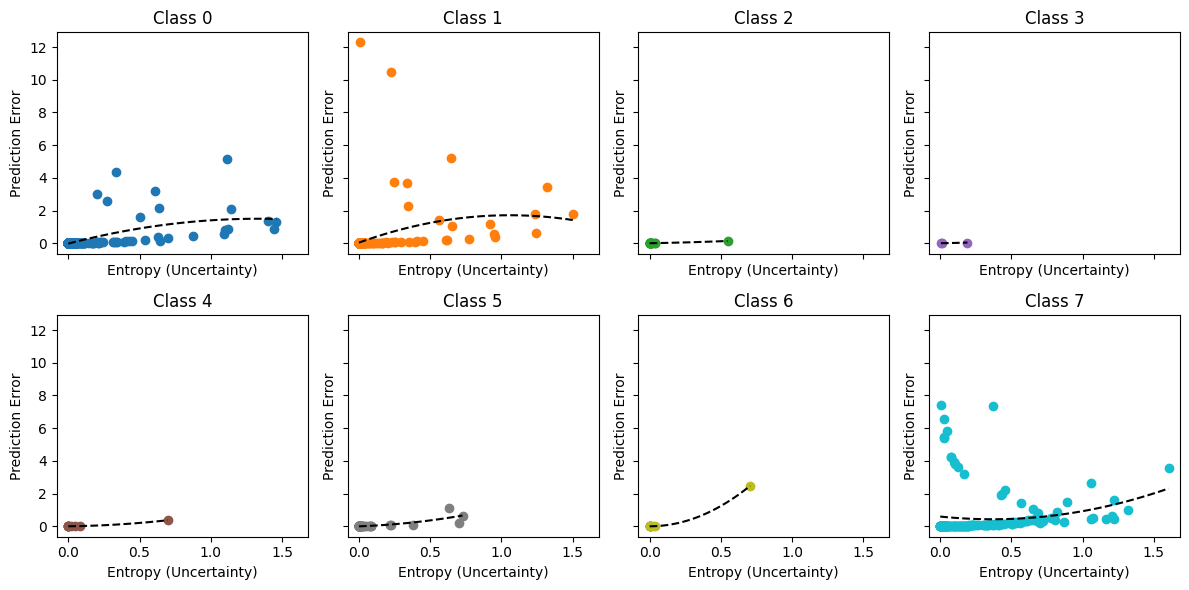

In [30]:
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

# Plot each class separately with a unique color
for i, (label, color) in enumerate(zip(unique_labels, colors)):
    row = i // 4
    col = i % 4
    indices = np.where(true_labels == label)
    axes[row, col].scatter(entropy[indices], prediction_errors[indices], label=f'Class {label}', color=color)
    axes[row, col].set_title(f'Class {label}')
    axes[row, col].set_xlabel('Entropy (Uncertainty)')
    axes[row, col].set_ylabel('Prediction Error')
    
    # Fit polynomial regression
    degree = 2
    poly_features = np.column_stack([entropy[indices], entropy[indices]**2])  # Create polynomial features
    lr = LinearRegression()
    lr.fit(poly_features, prediction_errors[indices])
    line_x = np.linspace(np.min(entropy[indices]), np.max(entropy[indices]), 100)
    line_y = lr.predict(np.column_stack([line_x, line_x**2]))  # Predict using polynomial features
    
    # Plot polynomial regression line
    axes[row, col].plot(line_x, line_y, color='black', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
# {0: '130228', 1: '47892', 2: '48537', 3: '48681', 4: '593040', 5: '59549', 6: '83653', 7: '914922'}
# {47892: 0.3714, 130228: 0.3025, 914922: 0.1638, 59549: 0.0658, 48537: 0.0338, 83653: 0.0146, 593040: 0.009, 48681: 0.0034}

High Errors with Low Uncertainty: The observation that low uncertainty is associated with high errors suggests that the model may be overly confident in its predictions when it shouldn't be. This could indicate areas where the model lacks robustness or where the training data may not adequately represent the complexity of the real-world scenarios. To address this, consider strategies for improving model calibration or collecting additional diverse data to capture edge cases and uncertainties better.
Decreasing Errors with Increasing Uncertainty: The trend where errors decrease as uncertainty increases suggests that the model is more cautious and tends to make more accurate predictions when it's uncertain. This is a positive sign as it indicates that the model is effectively leveraging uncertainty estimates to guide its decision-making process. However, it's essential to ensure that the model's uncertainty estimates are reliable and well-calibrated to make informed decisions.
Outliers with High Errors despite High Uncertainty: The points where errors are higher despite high uncertainty estimates could indicate specific failure modes or challenging scenarios where the model struggles to make accurate predictions even when it recognizes its uncertainty. Investigating these outliers can provide valuable insights into potential weaknesses or blind spots in the model architecture, feature representation, or training process. Consider conducting targeted analysis and experimentation to address these areas of concern and improve model performance.
Model Refinement and Evaluation: Based on your analysis, consider refining the model architecture, revisiting feature engineering strategies, or exploring alternative modeling approaches to address the observed patterns and improve overall performance. Additionally, continuously evaluate and monitor the model's performance on new data to ensure that any improvements generalize well across different scenarios and datasets.